In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn 
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, PrecisionRecallDisplay, RocCurveDisplay

In [2]:
data = pd.read_csv("../raw_data/file_with_mathtest_features.csv",low_memory=False)

## Variables

In [ ]:
data.columns

In [3]:
data = data.drop(columns=["Gender","darija","class_arabic","french","amazygh",
                    "read_one_lang","write_one_lang","type_housing","satellite","school_id",
                   "child_enrollment","class_when_dropout","schoolunitid","type_unit","groupid","num_menage",
                   "done_test"])

### Features cleaning (Math Test)

In [4]:
# Digit Recognition
data['digit_recognition_res'] = pd.to_numeric(data['digit_recognition_res'], errors='coerce')
data = data.dropna(subset=['digit_recognition_res'])

In [5]:
# Numbers Recognition
data['number_recognition_res'] = pd.to_numeric(data['number_recognition_res'], errors='coerce')
data = data.dropna(subset=['number_recognition_res'])

In [6]:
# Substraction
data['subtraction_res'] = pd.to_numeric(data['subtraction_res'], errors='coerce')
data = data.dropna(subset=['subtraction_res'])

In [7]:
# Division
data['division_res'] = pd.to_numeric(data['division_res'], errors='coerce')
data = data.dropna(subset=['division_res'])

<AxesSubplot:xlabel='division_res', ylabel='Count'>

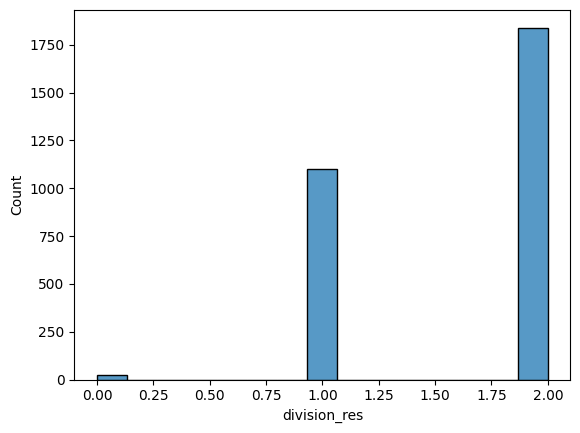

In [8]:
sns.histplot(data['division_res'])

### Define X, y 

In [15]:
X = data.drop("Age abandoned school", axis=1)
y = data["Age abandoned school"]

In [16]:
y.value_counts()

1.0    2247
0.0     722
Name: Age abandoned school, dtype: int64

In [17]:
target = {0:1,
         1:0}

In [18]:
y = y.map(target)

In [19]:
y.value_counts()

0    2247
1     722
Name: Age abandoned school, dtype: int64

In [20]:
X.columns

Index(['hhid', 'mother_alive', 'father_alive', 'parents_age', 'marital_status',
       'parents_level_ed', 'num_per_house', 'mobile_phones',
       'individual_water_net', 'work_activity_classified', 'average_score'],
      dtype='object')

### Remove features columns

In [9]:
data = data.drop(columns=["automobiles","region","province","electrical_net_co","no_water",
                    "no_read_write"])

In [10]:
data.shape

(2969, 15)

### Math test score - average

In [11]:
data['average_score'] = (data['digit_recognition_res'] + data['number_recognition_res'] + data['subtraction_res'] + data['division_res']) / 4


In [13]:
data = data.drop(columns=['number_recognition_res', 'subtraction_res', 'division_res',
       'digit_recognition_res'])

In [14]:
data.head()

,hhid,mother_alive,father_alive,parents_age,marital_status,parents_level_ed,num_per_house,mobile_phones,individual_water_net,Age abandoned school,work_activity_classified,average_score
0,A208004,1.0,1.0,35.0,1.0,1.0,5.0,1.0,2,1.0,1.0,1.75
2,A268006,1.0,1.0,31.0,1.0,3.0,7.0,1.0,2,1.0,0.0,1.50
4,A536006,2.0,1.0,36.0,1.0,2.0,4.0,1.0,2,1.0,1.0,1.25
6,A266008,1.0,1.0,43.0,1.0,3.0,7.0,2.0,2,1.0,0.0,1.00
7,A372007,1.0,1.0,33.0,1.0,3.0,4.0,1.0,2,0.0,0.0,1.25


In [32]:
data.isna().sum()

hhid                        0
mother_alive                0
father_alive                0
parents_age                 0
marital_status              0
parents_level_ed            0
num_per_house               0
mobile_phones               0
individual_water_net        0
Age abandoned school        0
work_activity_classified    0
average_score               0
dtype: int64

## Preprocessor

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

X_train.set_index('hhid', inplace=True)
X_test.set_index('hhid', inplace=True)

oversample = RandomOverSampler()
X_train, y_train = oversample.fit_resample(X_train, y_train)

X_train_num = X_train.select_dtypes(include=["float64","int64"])
X_test_num = X_test.select_dtypes(include=["float64","int64"])

pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="mean")),
    ('mm_scaler', MinMaxScaler())]).set_output(transform="pandas")

pipeline.fit(X_train_num)
X_train_transformed = pipeline.transform(X_train_num)
X_test_transformed = pipeline.transform(X_test_num)

## PCA & Features Transformation

### PCA

In [23]:
pca = PCA()
pca.fit(X_train_transformed)

# Metrics
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

# Dimensionality reduction (Train)
X_proj_train = pca.transform(X_train_transformed)
X_proj_train = pd.DataFrame(X_proj_train, columns=[f'PC{i}' for i in range(1, X_train_transformed.shape[1]+1)])

[0.28830066 0.21704392 0.15686478 0.1323467  0.10258469 0.04843406
 0.01838175 0.01512261 0.01337567 0.00754518]
[33.56767008 29.1254194  24.76059656 22.74337606 20.02348416 13.75858582
  8.4760157   7.68797114  7.23029768  5.43041713]


In [24]:
# Dimensionality reduction (Test)
X_proj_test = pca.transform(X_test_transformed)
X_proj_test = pd.DataFrame(X_proj_test, columns=[f'PC{i}' for i in range(1, X_test_transformed.shape[1]+1)])

## Grid Search

### Random Forest

In [ ]:
rf = RandomForestClassifier()

param_grid = {
    'n_estimators': [100, 200, 300],  
    'max_depth': [None, 5, 10],  
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 2, 4]  
}


search = GridSearchCV(
    rf,
    param_grid, 
    scoring = 'f1',
    cv = 5,
    n_jobs=-1
) 


search.fit(X_proj_train, y_train);

# Best score
print(search.best_score_)

# Best Params
print(search.best_params_) 

### Naive Bayse

In [ ]:
nb = GaussianNB()

param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7]  
}

search = GridSearchCV(nb, param_grid, cv=5, scoring='f1', n_jobs=-1)

search.fit(X_proj_train, y_train)

# Best score
print(search.best_score_)

# Best Params
print(search.best_params_) 

### SVC 

In [ ]:
svc = SVC() 

param_grid = {
    'C': [0.1, 1, 10],  
    'kernel': ['linear', 'rbf'],  
    'gamma': ['scale', 'auto']  
}

search = GridSearchCV(svc, param_grid, cv=5, scoring='f1', n_jobs=-1)

# Fit the Grid Search to your training data
search.fit(X_proj_train, y_train)

# Get the best parameters and best score from the Grid Search
print(search.best_params_)
print(search.best_score_)


## Final Pipeline

In [28]:
param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7]  
}

pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="mean")),
    ('mm_scaler', MinMaxScaler()),
    ('pca', PCA()),
    ('grid_search', GridSearchCV(GaussianNB(), param_grid, cv=5, scoring='f1',n_jobs=-1))
]).set_output(transform="pandas")

pipeline

Pipeline(steps=[('imputer', SimpleImputer()), ('mm_scaler', MinMaxScaler()),
                ('pca', PCA()),
                ('grid_search',
                 GridSearchCV(cv=5, estimator=GaussianNB(), n_jobs=-1,
                              param_grid={'var_smoothing': [1e-09, 1e-08,
                                                            1e-07]},
                              scoring='f1'))])

## Modeling (manual)

In [29]:
def perform(y_true, y_pred):
    print("Precision : ", precision_score(y_true, y_pred))
    print("Recall : ", recall_score(y_true, y_pred))
    print("Accuracy : ", accuracy_score(y_true, y_pred))
    print("F1 Score : ", f1_score(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    print("\n", cm)
    print("\n")
    print("**"*27 + "\n" + " "* 16 + "Classification Report\n" + "**"*27)
    print(classification_report(y_true, y_pred))
    print("**"*27+"\n")
    
    cm = ConfusionMatrixDisplay(confusion_matrix = cm)
    cm.plot()

### Naive Bayse

Precision :  0.32409972299168976
Recall :  0.7177914110429447
Accuracy :  0.5117845117845118
F1 Score :  0.4465648854961832

 [[187 244]
 [ 46 117]]


******************************************************
                Classification Report
******************************************************
              precision    recall  f1-score   support

           0       0.80      0.43      0.56       431
           1       0.32      0.72      0.45       163

    accuracy                           0.51       594
   macro avg       0.56      0.58      0.50       594
weighted avg       0.67      0.51      0.53       594

******************************************************



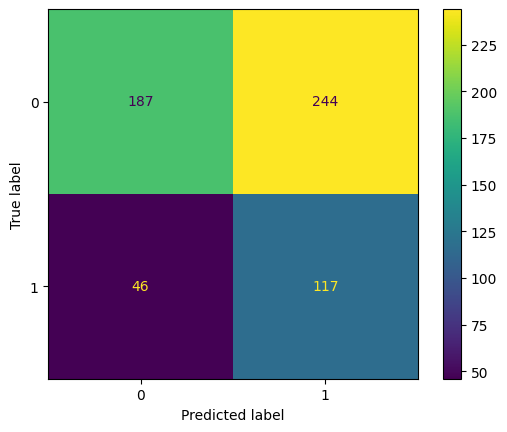

In [42]:
model_nb = GaussianNB(var_smoothing = 1e-09).fit(X_proj_train, y_train) 

# Performs Permutation
permutation_score = permutation_importance(model_nb, X_proj_train, y_train, n_repeats=10) 

# Unstack results showing the decrease in performance after shuffling features
importance_df = pd.DataFrame(np.vstack((X_proj_train.columns,
                                        permutation_score.importances_mean)).T) 
importance_df.columns=['feature','score decrease']

# Show the important features
importance_df.sort_values(by="score decrease", ascending = False) 

y_pred_nb = model_nb.predict(X_proj_test)
perform(y_test, y_pred_nb)

In [43]:
y_test.value_counts()

0    431
1    163
Name: Age abandoned school, dtype: int64

### SVC 

In [ ]:
model_svc = SVC(C= 10, gamma= "scale", kernel= "rbf")
model_svc.fit(X_proj_train, y_train) 

# Performs Permutation
permutation_score = permutation_importance(model_svc, X_proj_train, y_train, n_repeats=10) 

# Unstack results showing the decrease in performance after shuffling features
importance_df = pd.DataFrame(np.vstack((X_proj_train.columns,
                                        permutation_score.importances_mean)).T) 
importance_df.columns=['feature','score decrease']

# Show the important features
importance_df.sort_values(by="score decrease", ascending = False) 

y_pred_svc = model_svc.predict(X_proj_test)
perform(y_test, y_pred_svc)

### Random Forest

Precision :  0.3546099290780142
Recall :  0.3067484662576687
Accuracy :  0.6565656565656566
F1 Score :  0.3289473684210526

 [[340  91]
 [113  50]]


******************************************************
                Classification Report
******************************************************
              precision    recall  f1-score   support

           0       0.75      0.79      0.77       431
           1       0.35      0.31      0.33       163

    accuracy                           0.66       594
   macro avg       0.55      0.55      0.55       594
weighted avg       0.64      0.66      0.65       594

******************************************************



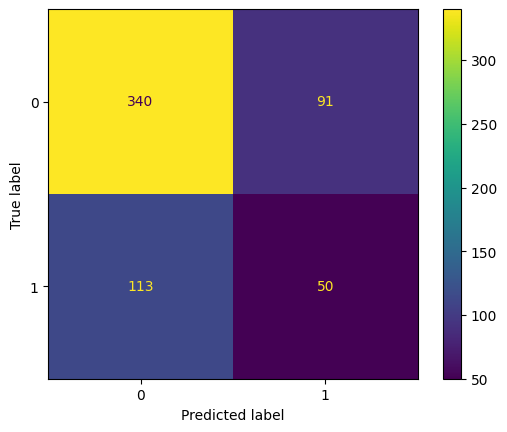

In [30]:
clf = RandomForestClassifier(max_depth= None, min_samples_leaf= 1, min_samples_split= 2, n_estimators= 200)

clf.fit(X_train, y_train)

# Performs Permutation
permutation_score = permutation_importance(clf, X_train, y_train, n_repeats=10) 

# Unstack results showing the decrease in performance after shuffling features
importance_df = pd.DataFrame(np.vstack((X_train.columns,
                                        permutation_score.importances_mean)).T) 
importance_df.columns=['feature','score decrease']

# Show the important features
importance_df.sort_values(by="score decrease", ascending = False) 

y_pred_clf = clf.predict(X_test)

perform(y_test, y_pred_clf)

## Precision/Recall trade off 

In [39]:
# To get the predict_proba for a model
proba_dropout, proba_enrolled =cross_val_predict(GaussianNB(),
                                                X_proj_train,
                                                y_train,
                                                cv=5,
                                                method='predict_proba').T

# precision recall data
precision, recall, threshold = precision_recall_curve(y_train, proba_dropout) 

print(f'precision- {precision[:5]}')
print(f'recall- {recall[:5]}')
print(f'threshold- {threshold[:5]}')

precision- [0.5        0.5001377  0.50027548 0.49986215 0.49972421]
recall- [1.         1.         1.         0.99834802 0.99779736]
threshold- [0.19699046 0.21623118 0.21942471 0.22266778 0.2243576 ]


In [40]:
# To view the scores in a DF
scores = pd.DataFrame({'threshold':threshold,
                       'precision': precision[1:],
                       'recall':recall[1:]}) # Store in a dataframe
scores

,threshold,precision,recall
0,0.196990,0.500138,1.000000
1,0.216231,0.500275,1.000000
2,0.219425,0.499862,0.998348
3,0.222668,0.499724,0.997797
4,0.224358,0.499862,0.997797
...,...,...,...
3207,0.998858,0.000000,0.000000
3208,0.999314,0.000000,0.000000
3209,0.999685,0.000000,0.000000
3210,0.999718,0.000000,0.000000


Text(0.5, 0, 'recall')

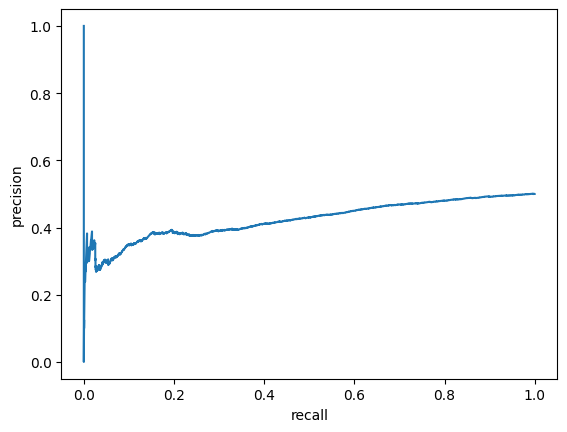

In [41]:
# Plotting Recall vs Precision
plt.plot(scores['recall'],scores['precision'])
plt.ylabel('precision')
plt.xlabel('recall')